In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.models import Model
import numpy as np
import seqdata

train = seqdata.Seq('train/')
test = seqdata.Seq('test/')

max_len = seqdata.pad_data(train, test)
max_len

2023-03-15 21:33:24.785125: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


3339

In [2]:
len(train)

2342

In [3]:
train.feature_extraction([1, 2, 3, 4, 5, 6, 7, 8], True)

In [4]:
test.feature_extraction([1, 2, 3, 4, 5, 6, 7, 8], False)

In [5]:
train.features

array([[ 1.3091419 , -1.2966676 , -2.3753762 , ..., -0.8258909 ,
        -0.60213995, -0.4214839 ],
       [ 2.7393308 , -2.7839572 , -2.652536  , ..., -1.3685424 ,
        -0.58461696, -0.351172  ],
       [-0.07086486, -0.42728546, -1.8170396 , ...,  0.20473984,
         0.10275402,  0.03944161],
       ...,
       [ 0.95696485, -1.1995386 , -1.007785  , ...,  0.501425  ,
         0.42393824,  0.3728538 ],
       [-0.4922409 ,  0.77606106, -0.17842649, ...,  0.38955942,
         0.33930767,  0.30033734],
       [-0.09512194,  0.48874465,  0.29257405, ...,  0.4260687 ,
         0.3805864 ,  0.33994618]], dtype=float32)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3339, 4)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 3337, 64)     832         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 3335, 64)     12352       ['conv1d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 3335, 64)     0           ['conv1d_1[0][0]']               
                                                                                              

2023-03-15 21:36:21.682809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 21:36:21.688222: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


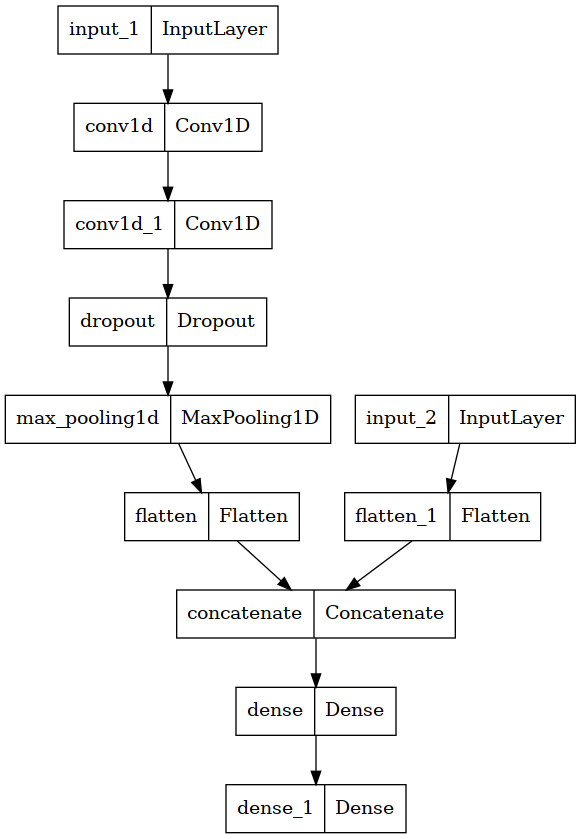

In [6]:
# Functional Model Keras

# cnn input

cnn_input = Input(shape=(max_len, 4))

x = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = Dropout(0.5)(x)
x = MaxPooling1D(pool_size=2)(x)
cnn_out = Flatten()(x)

# feature extraction input

feat_extraction_input = Input(shape=(426,))
feat_extraction_out = Flatten()(feat_extraction_input)

concat = Concatenate()([cnn_out, feat_extraction_out])

dense = Dense(128, activation='relu')(concat)

main_output = Dense(8, activation='softmax')(dense)

model = Model(inputs=[cnn_input,feat_extraction_input], outputs=main_output)

# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics= [tf.keras.metrics.Precision(class_id=i, name=name)for i, name in enumerate(train.names)])

model.summary()

tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [8]:
model.fit([train.seqs, train.features], train.labels, batch_size=32, epochs=10)

Epoch 1/10
74/74 [==============================] - 32s 418ms/step - loss: 0.6566 - snoRNA: 0.6316 - rRNA: 0.9583 - snRNA: 0.8158 - mRNA: 0.9014 - pre_miRNA: 0.5874 - miRNA: 0.6170 - tRNA: 0.9500 - tmRNA: 0.9391
Epoch 2/10
74/74 [==============================] - 35s 472ms/step - loss: 0.2831 - snoRNA: 0.7130 - rRNA: 0.9927 - snRNA: 0.8955 - mRNA: 0.9861 - pre_miRNA: 0.6910 - miRNA: 0.6855 - tRNA: 0.9915 - tmRNA: 0.9891
Epoch 3/10
74/74 [==============================] - 30s 404ms/step - loss: 0.1679 - snoRNA: 0.8583 - rRNA: 0.9963 - snRNA: 0.9620 - mRNA: 0.9980 - pre_miRNA: 0.7940 - miRNA: 0.7956 - tRNA: 0.9972 - tmRNA: 1.0000
Epoch 4/10
74/74 [==============================] - 31s 413ms/step - loss: 0.1095 - snoRNA: 0.9209 - rRNA: 0.9982 - snRNA: 0.9655 - mRNA: 1.0000 - pre_miRNA: 0.8317 - miRNA: 0.8520 - tRNA: 1.0000 - tmRNA: 1.0000
Epoch 5/10
74/74 [==============================] - 31s 415ms/step - loss: 0.0572 - snoRNA: 0.9714 - rRNA: 1.0000 - snRNA: 1.0000 - mRNA: 1.0000 - pre_m

In [9]:
vals = model.evaluate([test.seqs, test.features], test.labels)

val_dict = {test.names[i]: val for i, val in enumerate(vals[1:])}

val_dict

21/21 [==============================] - 2s 82ms/step - loss: 0.5273 - snoRNA: 0.6000 - rRNA: 0.9306 - snRNA: 0.6875 - mRNA: 0.9888 - pre_miRNA: 0.7188 - miRNA: 0.4932 - tRNA: 1.0000 - tmRNA: 1.0000    


{'snoRNA': 0.6000000238418579,
 'rRNA': 0.9305555820465088,
 'snRNA': 0.6875,
 'mRNA': 0.9888268113136292,
 'pre_miRNA': 0.71875,
 'miRNA': 0.4931506812572479,
 'tRNA': 1.0,
 'tmRNA': 1.0}

In [13]:
# cnn input

cnn_input = Input(shape=(max_len, 4))

x = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = Dropout(0.5)(x)
x = MaxPooling1D(pool_size=2)(x)
cnn_out = Flatten()(x)

dense = Dense(128, activation='relu')(cnn_out)

main_output = Dense(8, activation='softmax')(dense)

model = Model(inputs=cnn_input, outputs=main_output)

# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics= [tf.keras.metrics.Precision(class_id=i, name=name) for i, name in enumerate(train.names)])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3339, 4)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 3337, 64)          832       
                                                                 
 conv1d_4 (Conv1D)           (None, 3335, 64)          12352     
                                                                 
 dropout_2 (Dropout)         (None, 3335, 64)          0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1667, 64)         0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 106688)            0         
                                                           

In [14]:
model.fit(train.seqs, train.labels, batch_size=32, epochs=10)

Epoch 1/10
74/74 [==============================] - 32s 423ms/step - loss: 1.0895 - snoRNA: 0.0000e+00 - rRNA: 0.7618 - snRNA: 1.0000 - mRNA: 0.6876 - pre_miRNA: 0.5357 - miRNA: 0.4483 - tRNA: 0.9605 - tmRNA: 0.8988
Epoch 2/10
74/74 [==============================] - 29s 392ms/step - loss: 0.4816 - snoRNA: 0.7294 - rRNA: 0.9311 - snRNA: 0.9070 - mRNA: 0.8765 - pre_miRNA: 0.6441 - miRNA: 0.6700 - tRNA: 0.9693 - tmRNA: 0.9840
Epoch 3/10
74/74 [==============================] - 33s 441ms/step - loss: 0.2888 - snoRNA: 0.7830 - rRNA: 0.9828 - snRNA: 0.8841 - mRNA: 0.9382 - pre_miRNA: 0.7396 - miRNA: 0.7638 - tRNA: 0.9915 - tmRNA: 0.9962
Epoch 4/10
74/74 [==============================] - 32s 429ms/step - loss: 0.2009 - snoRNA: 0.8092 - rRNA: 0.9890 - snRNA: 0.9342 - mRNA: 0.9940 - pre_miRNA: 0.7937 - miRNA: 0.7386 - tRNA: 0.9887 - tmRNA: 1.0000
Epoch 5/10
74/74 [==============================] - 29s 398ms/step - loss: 0.1432 - snoRNA: 0.9008 - rRNA: 0.9909 - snRNA: 0.9639 - mRNA: 0.9941 - p

In [15]:
vals = model.evaluate(test.seqs, test.labels)

val_dict = {test.names[i]: val for i, val in enumerate(vals[1:])}

val_dict

21/21 [==============================] - 2s 93ms/step - loss: 0.6704 - snoRNA: 0.5185 - rRNA: 0.8811 - snRNA: 0.8182 - mRNA: 0.9058 - pre_miRNA: 0.5490 - miRNA: 0.4828 - tRNA: 0.9663 - tmRNA: 1.0000    


{'snoRNA': 0.5185185074806213,
 'rRNA': 0.881118893623352,
 'snRNA': 0.8181818127632141,
 'mRNA': 0.9057591557502747,
 'pre_miRNA': 0.5490196347236633,
 'miRNA': 0.48275861144065857,
 'tRNA': 0.966292142868042,
 'tmRNA': 1.0}